In [45]:
import pandas as pd
import numpy as np
from data_process import *
from metadata import *
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf
from plotly.offline import plot, iplot, download_plotlyjs, init_notebook_mode
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import homogeneity_score, completeness_score

init_notebook_mode(connected=True)
cf.go_offline()

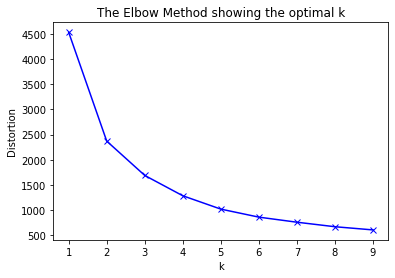

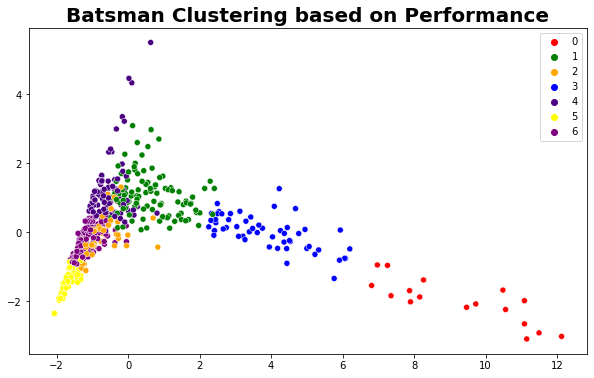

In [46]:
def cluster_batsman():
    batsman_df = season_batting_card_df
    batsman_df = batsman_df[['fullName', 'name', 'runs', 'ballsFaced', 'strikeRate', 'fours','sixes']]
    batsman_df['matches'] = 1
    # replcae NaN values with 0
    batsman_df = batsman_df.fillna(0)
    # replace INF values with 0
    batsman_df = batsman_df.replace(np.inf, 0)
    # replace - with 0
    batsman_df = batsman_df.replace("-", 0)
    batsman_df['runs'] = batsman_df['runs'].astype(int)
    batsman_df['ballsFaced'] = batsman_df['ballsFaced'].astype(int)
    batsman_df['strikeRate'] = batsman_df['strikeRate'].astype(float)
    batsman_df['fours'] = batsman_df['fours'].astype(int)
    batsman_df['sixes'] = batsman_df['sixes'].astype(int)
    
    batsman_df = batsman_df.groupby(['fullName','name']).sum().reset_index()
    batsman_df['strikeRate'] = batsman_df['strikeRate']/batsman_df['matches']

    # find batsman strike rate in first five overs and run in last five overs
    batsman_overs = season_details_df
    batsman_overs = batsman_overs[batsman_overs['isWide'] == False]
    batsman_overs = batsman_overs[batsman_overs['isNoball'] == False]
    batsman_overs = batsman_overs[['batsman1_name','over','runs']]
    batsman_overs['balls'] = 1
    batsman_overs = batsman_overs.groupby(['batsman1_name','over']).sum().reset_index()
    batsman_overs_start = batsman_overs[batsman_overs['over'] <= 5]
    batsman_overs_end = batsman_overs[batsman_overs['over'] >= 15]
    batsman_overs_start = batsman_overs_start.groupby(['batsman1_name']).sum().reset_index()
    batsman_overs_end = batsman_overs_end.groupby(['batsman1_name']).sum().reset_index()
    batsman_overs_start['strikeRate_start'] = batsman_overs_start['runs']*100/batsman_overs_start['balls']
    batsman_overs_end['strikeRate_end'] = batsman_overs_end['runs']*100/batsman_overs_end['balls']
    batsman_overs_start = batsman_overs_start[['batsman1_name','strikeRate_start']]
    batsman_overs_end = batsman_overs_end[['batsman1_name','strikeRate_end']]
    batsman_overs = pd.merge(batsman_overs_start, batsman_overs_end, on = 'batsman1_name',how = 'outer')
    batsman_overs = batsman_overs.fillna(0)
    # rename batsman1_name to fullName
    batsman_overs = batsman_overs.rename(columns = {'batsman1_name':'fullName'})

    # merging
    batsman_df = pd.merge(batsman_df, batsman_overs, on = 'fullName', how = 'left')
    batsman_df = batsman_df.fillna(0)

    # clustering batsman
    X_df = batsman_df.drop(['fullName','name'], axis = 1)
    X = StandardScaler().fit_transform(X_df)

    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # taking 7 as clusters
    model = KMeans(n_clusters=7, random_state=42, init='k-means++')
    model.fit(X)
    pred = model.predict(X)
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    plt.figure(figsize=(10,6))
    # plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pred, legend='full', palette=['red','green','orange','blue','indigo','yellow','purple'])
    plt.title('Batsman Clustering based on Performance', fontsize=20, fontweight='bold')
    plt.savefig('../img/pngs/batsman_clustering.png', facecolor='w', edgecolor='w')
    plt.show()

    batsman_df['cluster'] = pred
    # # top batsman in  cluster 0
    # batsman_0 = batsman_df[batsman_df['cluster'] == 0]
    # # sort batsman_0 by 'strikeRate'
    # batsman_0.sort_values('strikeRate', ascending=False, inplace=True)
    # print(batsman_0.head(10))
    return batsman_df

batsman_df = cluster_batsman()

In [47]:
# top batsman in  cluster 0
batsman_0 = batsman_df[batsman_df['cluster'] == 0]
# sort batsman_0 by 'strikeRate'
batsman_0.sort_values('strikeRate', ascending=False, inplace=True)
batsman_0.reset_index(drop=True, inplace=True)
batsman_0.head(10)

,fullName,name,runs,ballsFaced,strikeRate,fours,sixes,matches,strikeRate_start,strikeRate_end,cluster
0,Kieron Pollard,KA Pollard,3268,2182,134.203312,212,214,160,86.666667,172.950192,0
1,AB de Villiers,AB de Villiers,5162,3403,133.246059,413,251,170,118.571429,213.564356,0
2,Chris Gayle,CH Gayle,4965,3333,128.708298,404,357,141,135.929319,203.370787,0
3,MS Dhoni,MS Dhoni,4746,3494,125.730570,325,219,193,68.571429,167.007673,0
4,Yusuf Pathan,YK Pathan,3204,2241,124.845455,262,158,154,144.444444,155.607477,0
5,David Warner,DA Warner,5449,3893,122.165600,525,201,150,134.633854,182.117647,0
6,Shane Watson,SR Watson,3874,2809,119.235319,376,190,141,108.884688,192.284866,0
7,Robin Uthappa,RV Uthappa,4691,3613,119.140324,462,165,185,127.863526,172.946860,0
8,Suresh Raina,SK Raina,5528,4043,118.809050,506,203,200,128.932262,168.194842,0
9,Virat Kohli,V Kohli,6283,4835,116.892362,546,210,199,118.906942,182.654249,0


In [48]:
# top batsman in  cluster 0
batsman_3 = batsman_df[batsman_df['cluster'] == 3]
# sort batsman_0 by 'strikeRate'
batsman_3.sort_values('strikeRate', ascending=False, inplace=True)
batsman_3.reset_index(drop=True, inplace=True)
batsman_3.head(10)

,fullName,name,runs,ballsFaced,strikeRate,fours,sixes,matches,strikeRate_start,strikeRate_end,cluster
0,Andre Russell,AD Russell,1700,952,151.711429,119,143,70,175.000000,198.782609,3
1,Hardik Pandya,HH Pandya,1476,959,143.086000,97,98,85,62.068966,169.831547,3
2,Jos Buttler,JC Buttler,1968,1312,136.932656,194,90,64,155.959596,186.764706,3
3,Virender Sehwag,V Sehwag,2728,1755,133.586442,334,106,104,147.942387,200.000000,3
4,Suryakumar Yadav,SA Yadav,2341,1725,130.273800,261,68,100,138.586957,159.523810,3
5,Dwayne Bravo,DJ Bravo,1537,1180,129.011402,120,65,107,116.470588,164.625850,3
6,Rishabh Pant,RR Pant,2498,1694,128.987024,225,113,84,113.636364,190.088106,3
7,Ravindra Jadeja,RA Jadeja,2386,1862,128.235298,176,85,151,110.000000,147.778875,3
8,Chris Lynn,CA Lynn,1329,945,126.062857,132,66,42,141.239316,143.636364,3
9,KL Rahul,KL Rahul,3273,2400,126.057882,282,134,85,127.965180,182.908163,3


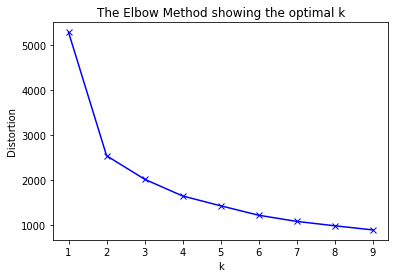

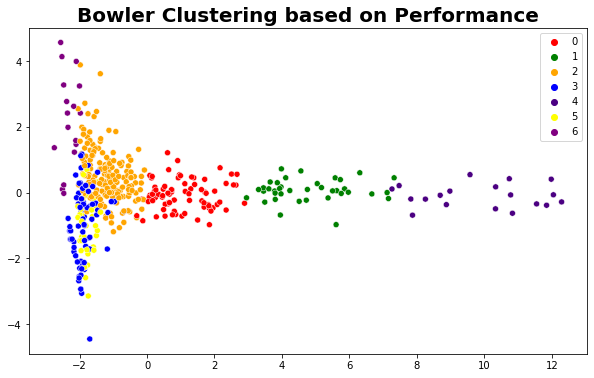

In [49]:
def overs_to_bowl(overs):
    overs = str(overs)
    over = int(overs.split('.')[0])
    bowl = int(overs.split('.')[1])
    return over*6 + bowl

def cluster_bowler():
    bowler_df = season_bowling_card_df
    bowler_df = bowler_df[['fullName','name','overs','maidens','conceded','wickets','economyRate','dots','foursConceded','sixesConceded']]
    bowler_df['matches'] = 1
    bowler_df['balls'] = bowler_df['overs'].map(overs_to_bowl)
    # replcae NaN values with 0
    bowler_df = bowler_df.fillna(0)
    # replace INF values with 0
    bowler_df = bowler_df.replace(np.inf, 0)
    # replace - with 0
    bowler_df = bowler_df.replace("-", 0)
    
    bowler_df['economyRate'] = bowler_df['economyRate'].astype(float)
    bowler_df = bowler_df.groupby(['fullName','name']).sum().reset_index()
    bowler_df['economyRate'] = bowler_df['economyRate']/bowler_df['matches']

    bowler_overs = season_details_df[['bowler1_name','over','runs']]
    bowler_overs['balls'] = 1
    bowler_overs = bowler_overs.groupby(['bowler1_name','over']).sum().reset_index()
    bowler_overs_start = bowler_overs[bowler_overs['over'] <= 5]
    bowler_overs_start = bowler_overs_start.groupby(['bowler1_name']).sum().reset_index()
    bowler_overs_end = bowler_overs[bowler_overs['over'] >= 15]   
    bowler_overs_end = bowler_overs_end.groupby(['bowler1_name']).sum().reset_index()
    bowler_overs_start['economyRate_start'] = bowler_overs_start['runs']*6/bowler_overs_start['balls']
    bowler_overs_end['economyRate_end'] = bowler_overs_end['runs']*6/bowler_overs_end['balls']
    bowler_overs_start = bowler_overs_start[['bowler1_name','economyRate_start']]
    bowler_overs_end = bowler_overs_end[['bowler1_name','economyRate_end']]
    bowler_overs = pd.merge(bowler_overs_start, bowler_overs_end, on = 'bowler1_name',how = 'outer')
    bowler_overs = bowler_overs.fillna(0)
    # rename bowler1_name to fullName
    bowler_overs = bowler_overs.rename(columns = {'bowler1_name':'fullName'})
    
    bowler_df = pd.merge(bowler_df, bowler_overs, on = 'fullName', how = 'left')
    bowler_df = bowler_df.fillna(0)

    # clustering bowler
    X_df = bowler_df.drop(['fullName','name'], axis = 1)
    X = StandardScaler().fit_transform(X_df)

    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)
    
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # taking 7 as clusters
    model = KMeans(n_clusters=7, random_state=42, init='k-means++')
    model.fit(X)
    pred = model.predict(X)
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    plt.figure(figsize=(10,6))
    # plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pred, legend='full', palette=['red','green','orange','blue','indigo','yellow','purple'])
    plt.title('Bowler Clustering based on Performance', fontsize=20, fontweight='bold')
    plt.savefig('../img/pngs/bowler_clustering.png', facecolor='w', edgecolor='w',)
    plt.show()

    bowler_df['cluster'] = pred
    return bowler_df

bowler_df = cluster_bowler()


In [50]:
# top bolwer in  cluster 0
bowler_4 = bowler_df[bowler_df['cluster'] ==4]
# sort batsman_0 by 'strikeRate'
bowler_4.sort_values('economyRate', ascending=False, inplace=True)
bowler_4.reset_index(drop=True, inplace=True)
bowler_4.head(10)
# bowler_4

,fullName,name,overs,maidens,conceded,wickets,economyRate,dots,foursConceded,sixesConceded,matches,balls,economyRate_start,economyRate_end,cluster
0,Dhawal Kulkarni,DS Kulkarni,296.3,8,2474,86,8.659457,765,271,81,92,1787,7.245018,9.345372,4
1,Umesh Yadav,UT Yadav,419.4,3,3579,119,8.659167,1019,393,116,120,2522,7.608247,9.955882,4
2,Dwayne Bravo,DJ Bravo,479.3,2,4032,166,8.372585,975,318,147,147,2889,8.132231,8.963014,4
3,Piyush Chawla,PP Chawla,543.8,2,4301,157,8.317012,1172,319,182,164,3274,7.272727,8.953846,4
4,Ishant Sharma,I Sharma,332.1,6,2701,72,8.180323,906,310,80,93,1997,6.943327,10.323353,4
5,Ravindra Jadeja,RA Jadeja,495.1,2,3779,125,8.066765,1005,230,160,170,2983,7.172414,8.512000,4
6,Irfan Pathan,IK Pathan,337.9,10,2649,80,7.937426,885,291,82,101,2043,6.918567,9.020833,4
7,Praveen Kumar,P Kumar,419.2,14,3251,90,7.911176,1147,338,104,119,2524,6.608527,10.140969,4
8,Sandeep Sharma,Sandeep Sharma,365.4,8,2849,112,7.816364,927,278,100,99,2198,6.721912,9.462406,4
9,Yuzvendra Chahal,YS Chahal,407.2,4,3097,139,7.741593,912,184,152,113,2448,7.666667,8.804878,4


In [51]:
# top bolwer in  cluster 0
bowler_1 = bowler_df[bowler_df['cluster'] ==1]
# sort batsman_0 by 'strikeRate'
bowler_1.sort_values('economyRate', ascending=False, inplace=True)
bowler_1.reset_index(drop=True, inplace=True)
bowler_1.head(10)

,fullName,name,overs,maidens,conceded,wickets,economyRate,dots,foursConceded,sixesConceded,matches,balls,economyRate_start,economyRate_end,cluster
0,Andre Russell,AD Russell,209.3,0,1901,72,9.376316,458,188,77,76,1261,8.506849,10.201373,1
1,Kieron Pollard,KA Pollard,232.4,0,2055,65,9.309604,401,160,72,101,1404,6.923077,9.512195,1
2,Jaydev Unadkat,JD Unadkat,294.8,3,2588,85,8.936588,612,220,114,85,1776,7.625232,10.485981,1
3,Shardul Thakur,SN Thakur,205.2,2,1829,64,8.904915,467,179,66,59,1236,8.494845,9.018557,1
4,James Faulkner,JP Faulkner,202.7,4,1778,59,8.785000,437,159,65,60,1227,7.273973,9.417582,1
5,Harshal Patel,HV Patel,210.0,0,1808,78,8.743770,454,163,67,61,1264,8.475728,9.088235,1
6,Mohammed Shami,Mohammed Shami,277.4,1,2402,79,8.702987,669,253,88,77,1670,7.658537,9.863014,1
7,Siddarth Kaul,S Kaul,196.1,3,1696,58,8.658519,404,161,63,54,1185,8.162162,8.728421,1
8,Mitchell McClenaghan,MJ McClenaghan,211.8,1,1803,71,8.560714,534,181,72,56,1274,7.500000,8.772152,1
9,Vinay Kumar,R Vinay Kumar,351.3,1,2966,105,8.475192,801,295,98,104,2121,7.282137,10.030096,1


In [52]:
batsman = batsman_df.copy()
batsman_price = price[price['Role'] != 'Bowler']
batsman_price = batsman_price[['Player','Price']]
batsman_price = batsman_price.rename(columns = {'Player':'fullName'})
batsman = pd.merge(batsman, batsman_price, on = 'fullName', how = 'inner')
data = batsman.drop(['fullName','name'],axis = 1)
# data = data.drop(['cluster'],axis = 1)
def clusters(price):
    if price <= 1:
        return 4
    if price <= 5:
        return 3
    if price <= 10:
        return 2
    return 1

batsman['price_cluster'] = batsman['Price'].apply(clusters)
batsman

,fullName,name,runs,ballsFaced,strikeRate,fours,sixes,matches,strikeRate_start,strikeRate_end,cluster,Price,price_cluster
0,AB de Villiers,AB de Villiers,5162,3403,133.246059,413,251,170,118.571429,213.564356,0,11.00,1
1,Abdul Samad,Abdul Samad,222,152,118.977778,12,14,18,0.000000,170.093458,4,0.20,4
2,Abhishek Sharma,Abhishek Sharma,241,173,122.455500,17,12,20,0.000000,145.192308,4,0.55,4
3,Aditya Tare,AP Tare,339,273,114.591786,40,11,28,109.890110,186.206897,1,0.20,4
4,Ajinkya Rahane,AM Rahane,3941,3248,101.075106,417,76,141,116.172507,152.207792,0,5.25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Virat Singh,Virat Singh,15,26,60.115000,1,0,2,0.000000,0.000000,5,1.90,3
95,Vishnu Vinod,Vishnu Vinod,19,26,90.553333,1,1,3,47.619048,180.000000,4,0.20,4
96,Washington Sundar,Washington Sundar,217,195,99.193077,17,6,26,73.913043,135.922330,1,3.20,3
97,Wriddhiman Saha,WP Saha,2110,1639,116.734074,191,69,108,139.263804,167.250000,3,1.20,3


In [53]:
# Run linear regression model
X = data.drop(['Price'], axis = 1)
y = data['Price']
Xscalar = StandardScaler()
X = Xscalar.fit_transform(X)
y = y.values.reshape(-1,1)
yscalar = StandardScaler()
y = yscalar.fit_transform(y)

model = LinearRegression()
model.fit(X,y)

print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)

# mean squared error
y_pred = model.predict(X)
print("Mean squared error: {:.2f}".format(mean_squared_error(y, y_pred)))




Coefficients: 
 [[ 8.82982891e+00 -5.36101869e+00 -3.64182525e-03 -2.18532352e+00
  -1.27831290e+00  2.92481991e-01  1.36619744e-01  1.02860803e-02
  -5.70796925e-02]]
Intercept: 
 [3.63647509e-16]
Mean squared error: 0.55


In [54]:
completeness_score(batsman['price_cluster'],batsman['cluster'])

0.14734606250689092

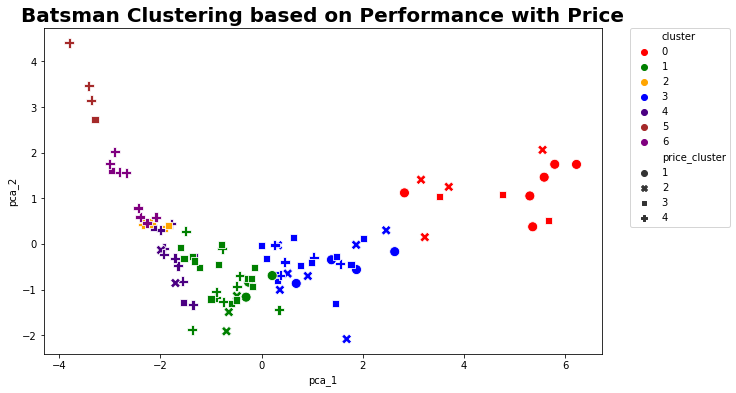

In [55]:
X = batsman.drop(['fullName','name','cluster','price_cluster','Price'], axis = 1)
X = StandardScaler().fit_transform(X)

X_pca = PCA(n_components=2).fit_transform(X)
clusters1 = batsman['cluster'].values
clusters2 = batsman['price_cluster'].values

batsman['pca_1'] = X_pca[:,0]
batsman['pca_2'] = X_pca[:,1]
# plot scatter plot showing clusters1 as color and clusters2 as marker
plt.figure(figsize=(10,6))
sns.scatterplot(data = batsman, x='pca_1', y='pca_2', hue='cluster', style = 'price_cluster', palette=['red','green','orange','blue','indigo','brown','purple'], s = 100)
plt.title('Batsman Clustering based on Performance with Price', fontsize=20, fontweight='bold')
# move legend to corner
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../img/pngs/batsman_clustering_price.png', facecolor='w', edgecolor='w',)